# Prediciting crop yield using weather data

The Netherlands is a farming country. 54% of its already small surface is being used for farming (CBS, 2018). In 2020, The Netherlands exported 95,6 billion euros worth of agricultural goods (Rijksoverheid, 2021). With that in mind, it comes as no surprise that the Netherlands is highly dependent on the performance of its farmers. Although farmers in the Netherlands are constantly using new ways to maximize their yields, there are still external factors that they cannot influence. 

One of these critical factors is the weather. Unexpected long periods of drought or very low temperatures are just some examples that can have a big impact on the yield of crops. The earth combined land and ocean temperature has increased at an average rate of 0.18 degrees Celcius per decade since 1981 (Lindsey & Dahlman, 2021). With global warming increasing worldwide, farmers must take the impact of the climate on their crops very serious. Therefore, the goal of this notebook is to use weather data to predict the yield of crops. Knowing beforehand what the yield of a particular crop is going to be has many practical implications. For example, farmers can use this data to determine what crops they should pick, predict their income, or how much they need to keep in storage. 

Moreover, the projected world population in 2050 is 9.7 billion (United Nations). Combined with global warming increasing worldwide, the need for food security is becoming an increasingly more serious issue for people, businesses and governments all over the world. Therefore, knowing beforehand what supply to expect from crops can be beneficial knowledge in determining strategies for battling food shortages.

## Exploring datasets
In this notebook, the weather data and crop data are collected separately. There are many different datasets for weather and crop data. In this section, some of these possible options are considered. Each dataset is cleaned and transformed to make them suitable for the model. Afterwards, the datasets are compared, and the most appropriate dataset for the model is chosen.


### Data set 1.0: weather data in the Netherlands
The first option is predicting the vegetable production in the Netherlands using Dutch weather data. 

Initially, the Climate Data API from The World Bank is used to gather the weather data. Although the data is already in the correct format, it only includes precipitation and temperature data. More data is needed for the model to work correctly. Therefore, it is decided to collect the weather data through the Meteostat Python library, which includes more extensive weather information such as minimum and maximum temperatures. Since the data on vegetable yield is only available from 1961 till 2014, the period for the weather data is set to match this. Meteostat collects data from each weather station in the world. In this case, the weather station in De Bilt (WMO code: 06260) is chosen because it is located central to the Netherlands and has the most complete data. The data frequency is then aggregated to a year since the crop data is also yearly. After the data is fetched, some steps are performed to clean the data.

In [25]:
# import packages
from datetime import datetime
from meteostat import Daily
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import warnings

In [26]:
# Climate Data API from The World Bank (unused)
#import precipitation data 
# pr = 'http://climatedataapi.worldbank.org/climateweb/rest/v1/country/cru/pr/year/ITA.csv'
# Precipitation = pd.read_csv(pr)

#import temperature data
# temp = 'http://climatedataapi.worldbank.org/climateweb/rest/v1/country/cru/tas/year/ITA.csv'
# Temperature = pd.read_csv(temp)

# Meteostat Python library
# Set time period
start = datetime(1961, 1, 1)
end = datetime(2014, 12, 31)

# Get daily data for weather station De Bilt
data = Daily('06260', start, end)
data = data.normalize()

# Aggregate to yearly data
data = data.aggregate('1Y')
data = data.fetch()

# reset index
data.reset_index(level=0, inplace=True)

# extract the year from datetime column
data['year'] = pd.DatetimeIndex(data['time']).year

# drop unnused and empty columns
data = data.drop(columns=['time', 'wpgt', 'tsun'])

# replace unealistic wind direction values with nan
data['wdir'].replace(0, np.nan, inplace=True)

data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,year
0,NaN,-11.7,32.2,925.4,0.2,NaN,NaN,NaN,1961
1,NaN,-11.5,27.0,749.9,2.2,NaN,NaN,NaN,1962
2,NaN,-18.2,28.7,776.7,14.0,NaN,NaN,NaN,1963
3,NaN,-12.7,31.7,760.1,1.3,NaN,NaN,NaN,1964
4,NaN,-10.0,27.6,1151.9,0.4,NaN,NaN,NaN,1965


### Data set 1.1: vegetable yied data in the Netherlands 

The data on crops is downloaded from the [Food and Agriculture Organization of the United Nations (FAO)](http://www.fao.org/faostat/en/#data/QC). This dataset contains data on many different types of crops in countries all over Europe. Therefore, the data is subsetted to only display the yield for primary vegetables in the Netherlands. Afterwards, unneeded columns are removed, year columns are turned into column values, and the crop data is merged with the weather data to form the final dataframe used to model the algorithm.

In [27]:
#import crop production data
crops_df = pd.read_csv('Production_Crops_E_Europe.csv')

#subset production data
crops_df = crops_df.loc[(crops_df['Area'] == 'Netherlands' ) & (crops_df['Item'] == 'Vegetables Primary')
                      & (crops_df['Element'] == 'Yield')]

#remove unneeded columns
crops_df = crops_df[crops_df.columns.drop(list(crops_df.filter(regex='F')))]
crops_df = crops_df.drop(columns=['Area Code', 'Item Code', 'Element Code'])

#remove Y from year columns
crops_df.columns = crops_df.columns.str.replace('Y','')

#turn year columns into values of one year column
crops_df = crops_df.melt(id_vars=["Area", 'Item', 'Element', "Unit"], 
        var_name="Date", 
        value_name="Value")

#convert years to integers
crops_df['Date']= crops_df['Date'].astype(int)

#rename columns
crops_df = crops_df.rename(columns={'Date':'year'})

#subset to match timeframes for all dataframes
crops_df = crops_df[crops_df['year'].between(1974, 2014)]

#merge the dataframes
df = reduce(lambda left,right: pd.merge(left,right,on='year'), [data, crops_df])

df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,year,Area,Item,Element,Unit,Value
0,9.7,-5.8,26.5,992.7,0.0,231.6,12.5,1013.9,1974,Netherlands,Vegetables Primary,Yield,hg/ha,308170.0
1,9.8,-7.8,32.9,635.0,0.1,214.8,12.1,1018.3,1975,Netherlands,Vegetables Primary,Yield,hg/ha,316115.0
2,10.0,-10.6,34.9,536.3,3.0,120.2,12.3,1017.0,1976,Netherlands,Vegetables Primary,Yield,hg/ha,340592.0
3,9.9,-5.3,30.8,813.0,0.2,223.4,11.7,1014.8,1977,Netherlands,Vegetables Primary,Yield,hg/ha,352223.0
4,9.1,-13.2,32.1,643.6,0.4,227.4,12.7,1013.7,1978,Netherlands,Vegetables Primary,Yield,hg/ha,357773.0


### Data set 2.0: weather data in Nebraska
The second option is predicting the corn yield in Nebraska, USA. Although the data from this option does not need to require extensive data cleaning steps, it is prefered over the first option since the weather data in Nebraska is much more complete. Therefore, the predictive model performed better.

The weather data from Nebraska is collected from the USA National Centers for Environmental Information (NCEI). The data from the weather station in Nebraska with the most complete data is collected from the NCEI website. The timespan of the resulting dataset is from 1981 till 2021. Unfortunately, the data is incomplete and has to be filtered to work for the predictive model. Therefore, the predictive model is run multiple times using different weather variables. Subsequently, the variables that show the best results (r^2 and rmse) are chosen as the final variables. You can look up what the variables mean by visiting the [NCEI webpage of the specific weather station used](https://www.ncdc.noaa.gov/cdo-web/datasets/GSOY/stations/GHCND:USC00252065/detail).

Due to advancements in farming technology, crop yields steadily increase over time. Therefore, the year has been taking into account as one of the independent variables.

In [28]:
# import Nebraska weather data
weather = pd.read_csv('NE_weather.csv') #https://www.ncdc.noaa.gov/cdo-web/datasets/GSOY/stations/GHCND:USC00252065/detail

# rename date column
weather = weather.rename(columns={'DATE':'Year'})

# filter for the most suitable weather variables
weather = weather[['Year', 
                   'TAVG', 'TMAX', 'TMIN', 'EMNT', 'EMXT', # Air temperature
                   'DX90', 'DT32',# Computed
                   'FZF5','FZF0', # Miscellany
                   'PRCP', 'DSNW', 'EMSN']] # Precipitation

# subset to match timeframes for all dataframes
weather = weather[weather['Year'].between(1916, 2020)]

weather.head()

,Year,TAVG,TMAX,TMIN,EMNT,EMXT,DX90,DT32,FZF5,FZF0,PRCP,DSNW,EMSN
24,1916,9.6,18.9,0.4,-28.3,40.0,67.0,178.0,-2.2,0.0,486.4,12.0,76.0
25,1917,9.6,19.0,0.2,-26.1,42.2,61.0,185.0,0.0,-5.6,377.5,6.0,76.0
26,1918,10.6,19.3,1.9,-34.4,41.7,64.0,162.0,-1.7,-4.4,505.6,14.0,152.0
27,1919,9.8,18.1,1.6,-33.9,40.6,72.0,174.0,-1.1,0.0,503.1,17.0,254.0
28,1920,9.9,18.6,1.2,-31.1,38.3,68.0,183.0,-1.1,-1.7,509.1,10.0,152.0


### Data set 2.1: corn yield in Nebraska
The data on corn yield in Nebraska is downloaded from the [U.S. Department of Agriculture (USDA)](https://www.nass.usda.gov/). This data shows the yield of corn measured in Bushels per Acre. [One bushel of corn weighs about 56 pounds or 25 kilograms](https://www.nefbfoundation.org/images/FOUndation/Educators/Enriching-Activities/Corn-Calculations.pdf). After importing the crop data, both the weather and crop dataframes are merged to form the final dataframe used for computing the predictive model. This dataframe will be used in the upcoming chapters of this notebook.

In [29]:
# import corn yield data
crops = pd.read_csv('NE_Corn.csv') #https://quickstats.nass.usda.gov/results/9C5879F6-ADFA-343F-A288-C2C6693E8C77

# filter out unused columns
crops = crops[['Year', 'Value']]

# subset to match timeframes for all dataframes
crops = crops[crops['Year'].between(1916, 2020)]

#merge the weather and crop dataframes
df_final = reduce(lambda left,right: pd.merge(left,right,on='Year'), [crops, weather])

# drop rows with Nan values
df_final = df_final.dropna()

df_final.head()

,Year,Value,TAVG,TMAX,TMIN,EMNT,EMXT,DX90,DT32,FZF5,FZF0,PRCP,DSNW,EMSN
0,2020,181.0,11.0,19.7,2.2,-19.4,39.4,77.0,170.0,0.0,-0.6,412.7,7.0,127.0
1,2019,182.0,9.8,17.6,2.0,-23.3,40.6,55.0,181.0,0.0,-0.6,632.9,11.0,178.0
2,2018,192.0,10.0,17.8,2.3,-22.2,40.6,61.0,177.0,0.0,-2.8,723.6,17.0,254.0
4,2016,178.0,12.0,20.4,3.6,-26.1,40.6,59.0,147.0,-0.6,-0.6,553.0,5.0,203.0
5,2015,185.0,11.7,19.8,3.6,-26.1,40.0,62.0,156.0,-1.7,0.0,638.2,9.0,127.0


### Descriptive analysis

To find relevant patterns in our dataset, we must analyze the data through exploratory data analysis. First, we will access basic statistical details like percentile, mean, and standard deviation using the pandas .describe() method.

In [30]:
# show statistics
df_final.describe()

,Year,Value,TAVG,TMAX,TMIN,EMNT,EMXT,DX90,DT32,FZF5,FZF0,PRCP,DSNW,EMSN
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.00000
mean,1967.044444,80.031111,10.624444,18.903333,2.337778,-25.846667,40.757778,60.777778,167.700000,-1.063333,-1.265556,525.238889,9.855556,163.70000
std,30.601796,57.360092,0.885249,1.081972,0.904741,4.028583,1.814980,14.378337,9.533442,1.282330,1.597341,110.301205,3.890528,66.27326
min,1916.000000,5.500000,8.600000,15.700000,-0.100000,-36.700000,36.100000,24.000000,147.000000,-5.600000,-9.400000,286.000000,2.000000,51.00000
25%,1941.250000,27.000000,9.925000,18.125000,1.825000,-28.900000,40.000000,52.000000,160.000000,-1.700000,-2.075000,462.700000,7.000000,123.25000
50%,1963.500000,58.750000,10.750000,18.900000,2.400000,-25.600000,40.600000,61.000000,168.000000,-0.600000,-0.600000,530.800000,9.000000,152.00000
75%,1993.750000,128.000000,11.000000,19.400000,2.800000,-23.300000,41.700000,69.750000,174.000000,0.000000,0.000000,605.200000,12.000000,203.00000
max,2020.000000,192.000000,13.300000,21.600000,4.900000,-15.600000,45.000000,92.000000,186.000000,0.000000,0.000000,755.900000,21.000000,356.00000


When looking at the table above, we can gather some interesting insights about the weather in Nebraska between 1916 and 2020. For example, the longest number of days with a maximum temperature above 32.2°C in one year was 92 days. The maximum extreme temperature reached was 45.0°C, and the lowest -15.6°C for the whole period.

Next, we will explore the relationships between all variables by plotting a correlation matrix, a heatmap and a pair plot. First, the correlation matrix and heatmap are plotted.

In [31]:
# correlation matrix
corr = df_final.corr()
corr

,Year,Value,TAVG,TMAX,TMIN,EMNT,EMXT,DX90,DT32,FZF5,FZF0,PRCP,DSNW,EMSN
Year,1.000000,0.956296,-0.149811,-0.277457,0.043565,0.365289,-0.236938,-0.311135,0.104264,0.101948,0.264768,0.282832,0.083859,0.102578
Value,0.956296,1.000000,-0.210708,-0.295292,-0.052338,0.322000,-0.301095,-0.345475,0.176028,0.152303,0.246069,0.323262,0.103236,0.057057
TAVG,-0.149811,-0.210708,1.000000,0.905886,0.861605,0.315320,0.530870,0.556032,-0.634845,-0.347622,-0.151258,-0.259605,-0.383273,-0.050377
TMAX,-0.277457,-0.295292,0.905886,1.000000,0.568150,0.202003,0.582652,0.625730,-0.415467,-0.349855,-0.262782,-0.402195,-0.492891,-0.154127
TMIN,0.043565,-0.052338,0.861605,0.568150,1.000000,0.366161,0.334964,0.323687,-0.736506,-0.274606,0.012773,-0.024335,-0.171444,0.088283
EMNT,0.365289,0.322000,0.315320,0.202003,0.366161,1.000000,-0.018405,0.041563,-0.078218,-0.054953,-0.013751,0.044804,-0.070905,0.028324
EMXT,-0.236938,-0.301095,0.530870,0.582652,0.334964,-0.018405,1.000000,0.673758,-0.266135,-0.355610,-0.316751,-0.458470,-0.160791,-0.021591
DX90,-0.311135,-0.345475,0.556032,0.625730,0.323687,0.041563,0.673758,1.000000,-0.209924,-0.307056,-0.207875,-0.606575,-0.203850,0.085994
DT32,0.104264,0.176028,-0.634845,-0.415467,-0.736506,-0.078218,-0.266135,-0.209924,1.000000,0.099069,-0.068007,-0.025571,0.161798,0.023935
FZF5,0.101948,0.152303,-0.347622,-0.349855,-0.274606,-0.054953,-0.355610,-0.307056,0.099069,1.000000,-0.033756,0.212036,0.117511,-0.070669


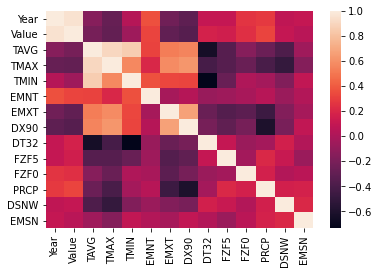

In [32]:
# heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

From the two figures above, we can result that Maximum temperature (TMAX) and Minimum temperature (TMIN) are most closely related to Average Temperature (TAVG). This is the case because when the temperature goes down, the average temperature goes down and vice versa. Another interesting relationship is between the number of days with maximum temperature above 32.2°C (DX90) and extreme maximum temperature for the period (EMXT), r(90) = 0.67. This positive relationship shows that when there were more prolonged periods of high temperatures in a year, the maximum temperature was usually also higher.

When we look at the relationships between the dependent variable (Value) and the other variables, we can see that the extreme minimum temperature (EMNT) is one of the most closely related to value. This positive relationship shows that when the extreme minimum temperature in a year is lower, the yield of corn is higher. This information gives an exciting insight into extreme weather conditions that significantly impact the yield of crops. Let's further explore the relationships between the dependent and independent variables by plotting a scatterplot matrix for the top five correlations. Note that the Year variable is included since the first plot is empty, and without, the EMNT plot would be empty.

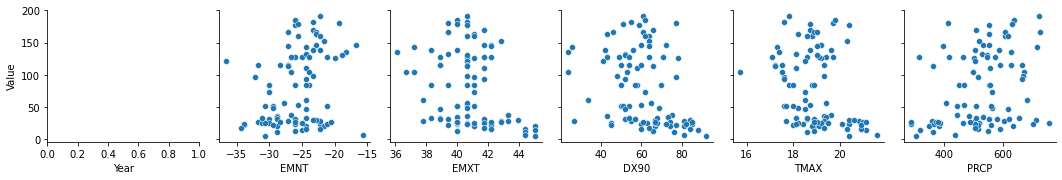

In [33]:
# scatterplot matrix
sns.pairplot(
    df_final,
    x_vars=['Year','EMNT', 'EMXT', 'DX90', 'TMAX','PRCP'],
    y_vars=['Value'])

At first, it is not entirely clear to spot the relationships with the naked eye. Therefore, let's look at the most considerable correlation between the number of days with a maximum temperature above 32.2°C (DX90) and Value, r(90) = -0.34.

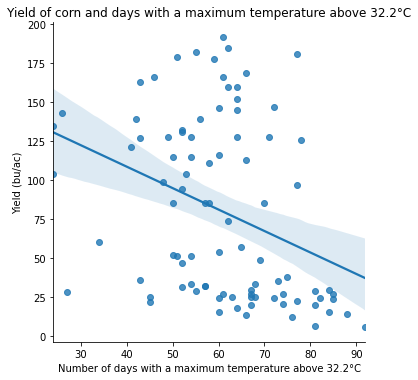

In [34]:
# relationship between DX90 and corn yield
sns.lmplot(x='DX90', y='Value', data=df_final)
plt.title('Yield of corn and days with a maximum temperature above 32.2°C')
plt.xlabel("Number of days with a maximum temperature above 32.2°C")
plt.ylabel("Yield (bu/ac)")
plt.show()

As can be seen above, the relationship is not that strong. However, just like with EMNT, having DX90 among the most correlated independent variables proves that extreme weather conditions can impact the yield of corn crops in Nebraska. In this case, the higher number of days where the temperature rose above 32.2°C, the lower the yield for that year. Next, let's take a look at the distribution of FZF0, which is an independent variable that shows the temperature value of the first freeze (at or less than 32 degrees Fahrenheit/0 degrees Celsius).

The median first freeze temperature is: -0.6 °C
The mean first freeze temperature is: -1.2655555555555553 °C


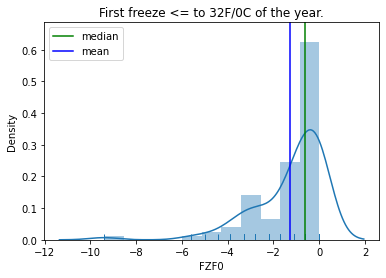

In [35]:
# remove warning
warnings.filterwarnings('ignore')

#calculate and print mean and median for FZF0
mean_size = df_final['FZF0'].mean()
median_size = df_final['FZF0'].median()
print(f'The median first freeze temperature is: {median_size} °C')
print(f'The mean first freeze temperature is: {mean_size} °C')

# plot the distribution of FZF0 with Kernel Density Estimate, median and mean values and actual values
sns.distplot(df_final['FZF0'], rug=True)
plt.title('First freeze <= to 32F/0C of the year.')
plt.axvline(median_size, 0, 100, color='green', label='median')
plt.axvline(mean_size, 0, 100, color='blue', label='mean') 
plt.legend() 
plt.show()

Some things to note about this distribution:

* It has one peak (or mode - unimodal)
* It has a 'tail' on the left (left-skewed)

Because the distribution is left-skewed, the median is higher than the mean. In the plot above, the Kernel Density Estimate is also plotted, which shows impossible values. Therefore the actual values are plotted as well.

### Predictive model

When considering the weather for predicting crop yields, many would assume that they are linearly related. For example, more rain would result in higher yields. However, we should also consider the impact that extreme weather conditions have on the yield of crops. Long periods of drought or extensive amounts of rain can have a massive effect on the yield of the crops. Therefore, we will explore two different predictive models, one linear and one non-linear. Afterwards, we will evaluate each model to see if the existence of critical thresholds also characterizes the relationship between weather and corn yield.
#### Multiple linear regression

Multiple linear regression is a linear model with multiple independent variables (predictors). When considering multiple independent variables, a concern with multiple regression is overfitting. That is when a model can very precisely predict the values for a particular dataset but fails when it has to predict from new data. Therefore we split the data into a train set and a test set. Below, the independent and dependent variables are selected, and the data is split into a training set and a test set. 

In [36]:
# split the data
X = df_final.drop(columns='Value')
y = df_final['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Afterwards, the linear model is trained

In [37]:
# Multiple linear regression
lm = LinearRegression() 
model = lm.fit(X_train, y_train) 

#### Random Forest Regressor

The second predictive model is Random Forest Regressor. Random forest is a supervised algorithm with high accuracy. Where other predictive models struggle with overfitting, random forest has less overfitting because if there are enough trees in the forest, the classifier won’t overfit the model. The disadvantage of that is that the algorithm is harder to understand. Besides that, having a large number of trees can make the algorithm too slow. In this case, the model is initially trained using 50 trees or estimators.

In [38]:
# Random forrestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators=50)
rf = rf.fit(X_train, y_train)

### Evaluation 
To decide which model is best, we must evaluate the performance of each model and see if we can improve them by exploring different parameters.

#### Evaluation of multiple linear regression
At first, we evaluate the performance of the multiple linear regression model. First, we make predictions for the test data and calculate the R^2 score.

In [39]:
# calculate the R^2 score for the linear regression model
y_test_p_lm = lm.predict(X_test)
R2_LR = r2_score(y_test, y_test_p_lm)
print(f'The R^2 score for the multiple linear regression model is: {R2_LR}')

The R^2 score for the multiple linear regression model is: 0.8646699727207402


The R^2 is 0.86, which means the model explains 86% of the variation in yield. Next, we calculate the root mean squared error (RMSE).

In [40]:
# calculate the RMSE for the linear regression model
RMSE_LR = math.sqrt(mean_squared_error(y_test, y_test_p_lm))
print(f'The RMSE for the multiple linear regression model is: {RMSE_LR}')

The RMSE for the multiple linear regression model is: 18.303516192812673


The RMSE is 18.30. This means that we are typically about 18.30 bachels (464.82 Kg) per acre off in our predicted yield compared to the actual yield. Finally, let's plot the predicted yield against the actual yield.

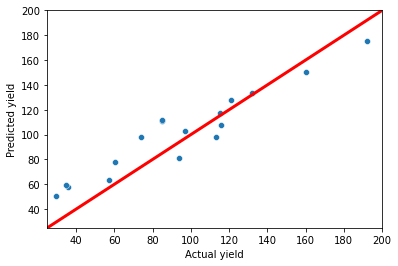

In [41]:
# plot predicted yield against actual yield for the linear regression model
sns.scatterplot(x=y_test, y=y_test_p_lm)
plt.xlabel('Actual yield')
plt.ylabel('Predicted yield')
plt.xlim([25,200]) 
plt.ylim([25,200])
plt.plot([25, 200], [25, 200], color='red', lw=3)
plt.show()

Overall, we can see that the model does quite well at predicting the actual yield. There are no significant outliers from the main line, which means that the model performs quite well for the whole yield range (from low to high).

#### Evaluation of random forest regressor

As with the multiple linear regression model, we start evaluating the random forest regression model by calculating the R^2 score.

In [42]:
# calculate the R^2 score for the linear regression model
y_test_p_rf = rf.predict(X_test)
R2_RF = r2_score(y_test, y_test_p_rf)
print(f'The R^2 score for the random forest regressor model is: {R2_RF}')

The R^2 score for the random forest regressor model is: 0.956982177289942


The R^2 is 0.96, which means the model explains 96% of the variation in yield. Next, we calculate the root mean squared error (RMSE).

In [43]:
# calculate the RMSE for the linear regression model
RMSE_RF = math.sqrt(mean_squared_error(y_test, y_test_p_rf))
print(f'The RMSE for the multiple linear regression model is: {RMSE_LR}')

The RMSE for the multiple linear regression model is: 18.303516192812673


The RMSE is 18.30. This means that we are typically about 18.30 bachels (464.82 Kg) per acre off in our predicted yield. Finally, let's plot the predicted yield against the actual yield.

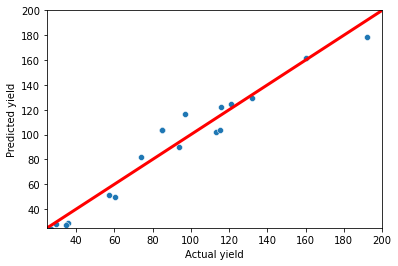

In [44]:
# plot predicted yield against actual yield for the random forest model
sns.scatterplot(x=y_test, y=y_test_p_rf)
plt.xlabel('Actual yield')
plt.ylabel('Predicted yield')
plt.xlim([25,200]) 
plt.ylim([25,200])
plt.plot([25, 200], [25, 200], color='red', lw=3)
plt.show()

#### Model conclusion
When we compare the scores from both models, we can conclude that the random forest regression model performs better than the multiple regression model. Now let's see if we can improve the performance of the random forest model by adjusting different parameters. First, let's see the impact on the scores when we change the split in the data so that the training data is 80% of all the data.

In [45]:
# split the data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Random forrestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators=50)
rf = rf.fit(X_train, y_train)

# calculate R^2 score and RMSE for updated random forest model
y_test_p_rf = rf.predict(X_test)
R2_RF = r2_score(y_test, y_test_p_rf)
print(f'The R^2 score for the random forest regressor model is: {R2_RF}')
RMSE_RF = math.sqrt(mean_squared_error(y_test, y_test_p_rf))
print(f'The RMSE for the multiple linear regression model is: {RMSE_LR}')

The R^2 score for the random forest regressor model is: 0.9753541664107408
The RMSE for the multiple linear regression model is: 18.303516192812673


After changing the data split, we can see a slight improvement in the model. The R^2 score has increased from 96% to 98%. The RMSE stayed the same with 18.30 bachels (464.82 Kg) per acre. Now, let's see if we can further improve the model by adjusting the random state in splitting the dataset.

In [46]:
# change random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Random forrestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators=50)
rf = rf.fit(X_train, y_train)

# calculate R^2 score and RMSE for updated random forest model
y_test_p_rf = rf.predict(X_test)
R2_RF = r2_score(y_test, y_test_p_rf)
print(f'The R^2 score for the random forest regressor model is: {R2_RF}')
RMSE_RF = math.sqrt(mean_squared_error(y_test, y_test_p_rf))
print(f'The RMSE for the multiple linear regression model is: {RMSE_LR}')

The R^2 score for the random forest regressor model is: 0.9888716004142413
The RMSE for the multiple linear regression model is: 18.303516192812673


Again, we can see a slight improvement in the model. The R^2 score has increased from 98% to 99%. The RMSE stayed the same with 18.30 bachels (464.82 Kg) per acre. Now, let's see if we can improve the model further by adjusting the number of trees in the forest.

In [47]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# change n_estimators
rf = RandomForestRegressor(random_state=1, n_estimators=100)
rf = rf.fit(X_train, y_train)

# calculate R^2 score and RMSE for updated random forest model
y_test_p_rf = rf.predict(X_test)
R2_RF = r2_score(y_test, y_test_p_rf)
print(f'The R^2 score for the random forest regressor model is: {R2_RF}')
RMSE_RF = math.sqrt(mean_squared_error(y_test, y_test_p_rf))
print(f'The RMSE for the multiple linear regression model is: {RMSE_LR}')

The R^2 score for the random forest regressor model is: 0.9879860249555087
The RMSE for the multiple linear regression model is: 18.303516192812673


This time, the R^2 score has decreased slightly. The RMSE has stayed the same. Finally, let's plot the final predicted yield against the actual yield for the best performing version of the model.

The R^2 score for the random forest regressor model is: 0.9888716004142413
The RMSE for the multiple linear regression model is: 18.303516192812673


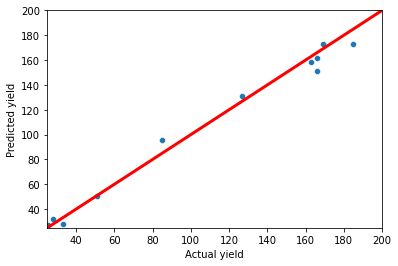

In [24]:
# split the data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Random forrestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators=50)
rf = rf.fit(X_train, y_train)

# calculate R^2 score and RMSE for updated random forest model
y_test_p_rf = rf.predict(X_test)
R2_RF = r2_score(y_test, y_test_p_rf)
print(f'The R^2 score for the random forest regressor model is: {R2_RF}')
RMSE_RF = math.sqrt(mean_squared_error(y_test, y_test_p_rf))
print(f'The RMSE for the multiple linear regression model is: {RMSE_LR}')

# plot predicted yield against actual yield for the random forest model
sns.scatterplot(x=y_test, y=y_test_p_rf)
plt.xlabel('Actual yield')
plt.ylabel('Predicted yield')
plt.xlim([25,200]) 
plt.ylim([25,200])
plt.plot([25, 200], [25, 200], color='red', lw=3)
plt.show()

### Final conclusion and discussion
As can be seen above, after optimizing the model, the predicted values have come much closer to the actual values compared to the multiple linear regression model. Since some of the points are below the red line at the right part of the graph, we can conclude that this model has a slight tendency to undershoot for higher yields.

Because this model performs well, it does have some practical implications. However, since the RMSE is higher than the actual change in yield from year to year, it is not suggested to use this model to predict the yield for the upcoming ten years or so. When considering the growing population, global warming, and food security, this model can give a good prediction on corn yield for the years after. This information can, in turn, be useful for policymakers that struggle with battling food security. However, this model does need some extensive and detailed weather information to work correctly. Concerning the fact that global warming is making our weather more unpredictable, it is hard to say if we will be able to predict this type of weather information. It is therefore unlikely that this model works properly for predicting future corn yields in Nebraska. Moreover, since the increase in corn yield is highly correlated with the year, it should be noted that a similar model could most likely be constructed without the weather variables.

### References 

<br> CBS. (2018, September 7). Bodemgebruik; uitgebreide gebruiksvorm, per gemeente. Opgehaald van https://opendata.cbs.nl/: https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70262ned/table?fromstatweb

<br> Lindsey, R., & Dahlman, L. (2021, March 15). Climate Change: Global Temperature. Opgehaald van Climate.Gov: https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature#:~:text=According%20to%20NOAA's%202020%20Annual,more%20than%20twice%20that%20rate.

<br> Meteostat Developers. (sd). Meteostat Developers. Opgehaald van https://dev.meteostat.net/: https://dev.meteostat.net/

<br> Rijksoverheid. (2021, January 22). Nederlandse landbouwexport in 2020 95,6 miljard euro. Opgehaald van https://www.rijksoverheid.nl/: https://www.rijksoverheid.nl/actueel/nieuws/2021/01/22/nederlandse-landbouwexport-in-2020-956-miljard-euro#:~:text=Nederland%20exporteerde%20in%202020%20voor,van%20landbouwgoederen%20van%20buitenlandse%20makelij.

<br> United Nations. (sd). Population. Opgehaald van https://www.un.org/: https://www.un.org/en/global-issues/population

